In [122]:
from math import isnan
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from numpy import round

## Предварительный анализ

In [123]:
df = pd.read_csv('ecom_raw.csv', sep=',', decimal=".")
df.columns = [x.lower().replace(" ", "_") for x in df.columns]
df.head()

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


In [124]:
# функция для расчета тройного интерквартильного размаха
def inq(col):
    return df[col].quantile(.75) + (df[col].quantile(.75) - df[col].quantile(.25)) * 3

### Устранение пропусков по данным

Строки с пропусками составляют 1.28%


<Axes: >

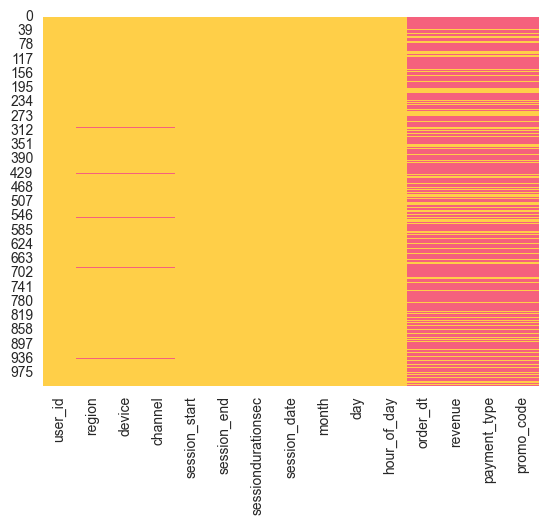

In [125]:
colours = ['#FFCF48', '#F5617D']
print(f'Строки с пропусками составляют {round(df["channel"].isna().value_counts()[True] / len(df["channel"]) * 100, 2)}%')
sns.heatmap(df.isna(), cmap=sns.color_palette(colours), cbar=False)

Есть пропуски в категориальных данных, пропущен регион, устройство и тип канала. 
После поиска по индексу в пропусках было обнаружено, что некоторые индексы совпадают с темикоторые ранее были найдены в датасете. 
Было принято решение подставить эти категориальные данные, а те строки, 
id которых ранее не встречался или в нем тоже отсутствуют категориальные данные, было принято решение удалить

In [126]:
df1 = pd.DataFrame(df[df["region"].isnull()]["user_id"])
values = pd.DataFrame(df["user_id"].value_counts())
for uid in df1["user_id"]:
    if values.loc[uid, "count"] == 2:
        line2 = df.loc[df["user_id"] == uid].iloc[0]
        df.loc[df["user_id"] == uid, "device"] = line2["device"]
        df.loc[df["user_id"] == uid, "region"] = line2["region"]
        df.loc[df["user_id"] == uid, "channel"] = line2["channel"]
df = df.dropna(how="any", subset=["channel", "region"])
df = df.reset_index(drop=True)

<Axes: >

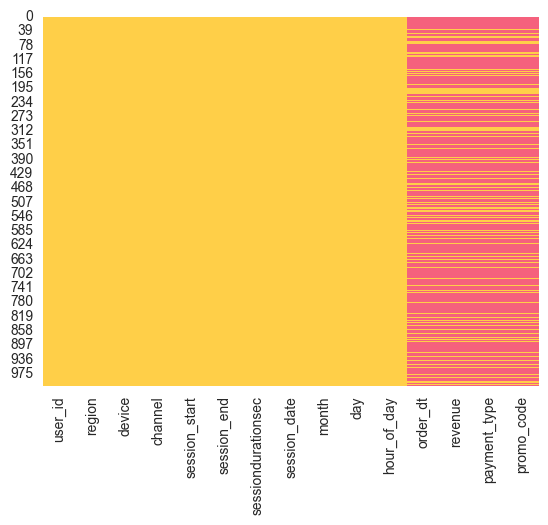

In [127]:
df.dropna(how="any", subset=["channel", "region"], inplace=True)
sns.heatmap(df.isna(), cmap=sns.color_palette(colours), cbar=False)

Столбец “payer” с информацией о том, является ли пользователь платящим или нет

In [128]:
df["payer"] = df["revenue"].apply(lambda x: int(not isnan(x)))
# Округление длительности сессии (так как все числа очень близки к целому, вероятно ошибка в процессе передачи)
df["sessiondurationsec"] = df["sessiondurationsec"].apply(round)

Устранение явных дубликатов и ошибок в категориальных данных

In [129]:
if len(df["user_id"]) != len(list(set(df["user_id"]))):
    df = df.drop_duplicates(subset=["user_id"], ignore_index=True)

df.loc[df["channel"] == "контексная реклама", "channel"] = "контекстная реклама"
df.loc[df["device"] == "android", "device"] = "Android"
df.loc[df["region"] == "Unjted States", "region"] = "United States"
df.loc[df["region"] == "germany", "region"] = "Germany"
df.loc[df["region"] == "Franсe", "region"] = "France"
df.loc[df["region"] == "Frаnce", "region"] = "France"
df.loc[df["region"] == "Frаncе", "region"] = "France"
df.loc[df["region"] == "UК", "region"] = "UK"

Преобразование данных с временными значениями и проверка на ошибки

In [130]:
df["session_start"] = pd.to_datetime(df["session_start"])
df["session_end"] = pd.to_datetime(df["session_end"])
df["session_date"] = pd.to_datetime(df["session_date"])
df["order_dt"] = pd.to_datetime(df["order_dt"])

In [131]:
for index, row in df.iterrows():
    row_has_mistake = 0
    if row["session_start"] > row["session_end"] or row["sessiondurationsec"] < 0 :
        row_has_mistake = 1
    if row["session_date"].date() != row["session_start"].date():
        row_has_mistake = 1
    if row["month"] != row["session_date"].month or row["day"] != row["session_date"].day_of_week + 1:
        row_has_mistake = 1
    if row_has_mistake:
        print("Обнаружена ошибка в данных")

### Период исследования

Исследуемый период с 2019-10-31 по 2019-05-01 продолжительностью 183 дня


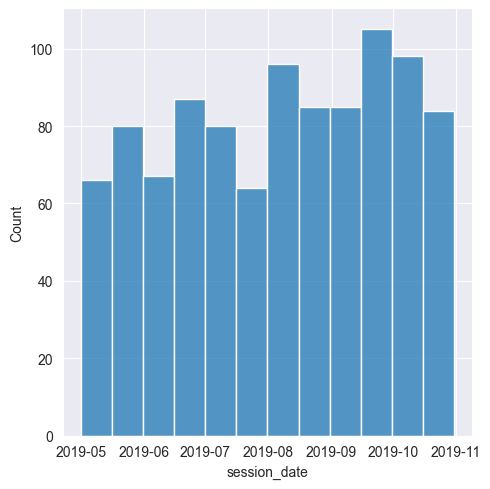

In [132]:
print(f'Исследуемый период с {max(df["session_date"]).date()} по {min(df["session_date"]).date()} продолжительностью'
      f' {(max(df["session_date"]) - min(df["session_date"])).days} дня')
sns.displot(df["session_date"], bins=12)

После построения гистограммы по месяцам видно, что количество записей распределены по месяцам ненормально, но при этом нет выбросов, поэтому стоит учитывать весь период.

### Работа с выбросами

<Axes: ylabel='sessiondurationsec'>

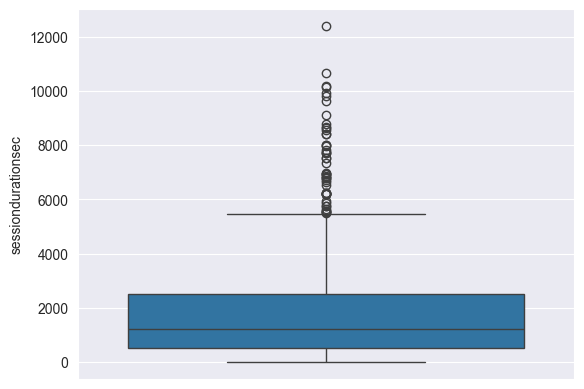

In [133]:
sns.boxplot(df["sessiondurationsec"])

<Axes: ylabel='revenue'>

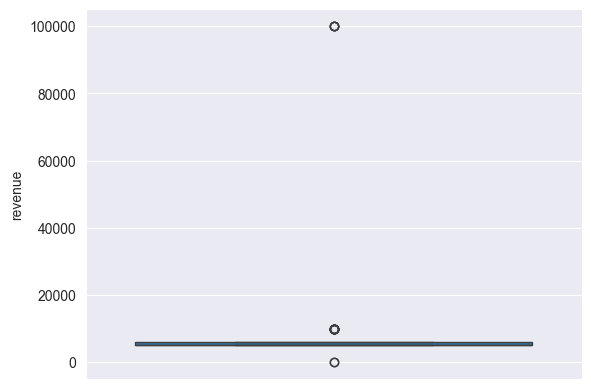

In [134]:
sns.boxplot(df["revenue"])

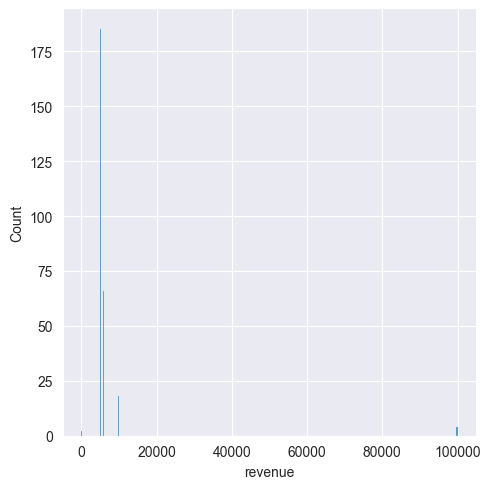

In [135]:
sns.displot(df.loc[df["payer"] == 1, "revenue"])

Есть выбросы в большую сторону в длительности сессиии и доходе.\
Принято решение устранить их методом тройного интерквартильного размаха.\
Значения выбросов заменены медианой по группе канала рекламы и по региону.

In [136]:
# Устранение выбросов
channels = list(set(df["channel"]))
regions = list(set(df["region"]))
sigma_revenue = round(df.loc[df["payer"] == 1, "revenue"].std())
mean_revenue = round(df.loc[df["payer"] == 1, "revenue"].mean())
for channel_type in channels:
    for region in regions:
        median_sessionduration = df.loc[(df["channel"] == channel_type) & (df["region"] == region), "sessiondurationsec"].median()
        if isnan(median_sessionduration):
            median_sessionduration = df.loc[(df["channel"] == channel_type), "sessiondurationsec"].median()
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) &
               (df["sessiondurationsec"] > inq("sessiondurationsec")), "sessiondurationsec"] = int(median_sessionduration)

        median_revenue = df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (df["payer"] == 1), "revenue"].median()
        if isnan(median_revenue):
            median_revenue = df.loc[(df["channel"] == channel_type) & (df["payer"] == 1), "revenue"].median()
        if median_revenue == 5499:
            median_revenue = 4999
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (
                df["revenue"] > mean_revenue + sigma_revenue) & (df["payer"] == 1), "revenue"] = int(median_revenue)
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (
                    df["revenue"] < abs(mean_revenue - sigma_revenue)) & (df["payer"] == 1), "revenue"] = int(median_revenue)

Для дохода было принято решение использовать правило сигмы, так как интерквартильный размах отсекал данные, которые не показались команде выбросами

### Добавление новых столбцов

In [137]:
# функция для добавления нового столбца в зависимости от времени суток визита
def sort_by_time_of_day(time):
    time = time.hour
    if 10 > time >= 6:
        return "утро"
    if 17 > time >= 10:
        return "день"
    if 22 > time >= 17:
        return "вечер"
    if time >= 22 or time < 6:
        return "ночь"


# Добавление столбца "time_of_day" в зависимости от времени суток
df["time_of_day"] = df["session_start"].apply(sort_by_time_of_day)

In [138]:
# Добавление столбца "promo_code" с итоговой суммой покупки после промокода 10%
df["final_price"] = df["revenue"]
df.loc[df["promo_code"] == 1, "final_price"] = df.loc[df["promo_code"] == 1, "final_price"].apply(lambda x: round(x * 0.9))

### Графический анализ

Text(0.5, 0.98, 'Доля продаж по регионам')

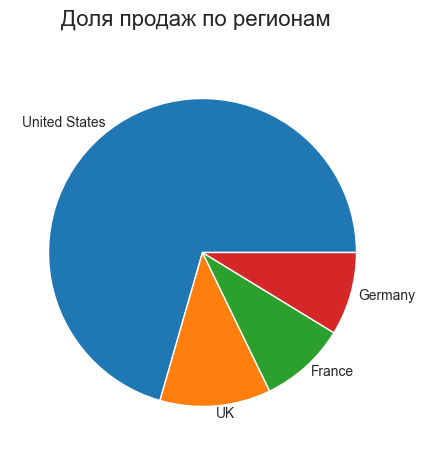

In [139]:
y = df.loc[df["payer"] == 1, "region"].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по регионам", size=16)

Text(0.5, 0.98, 'Доля продаж по источникам')

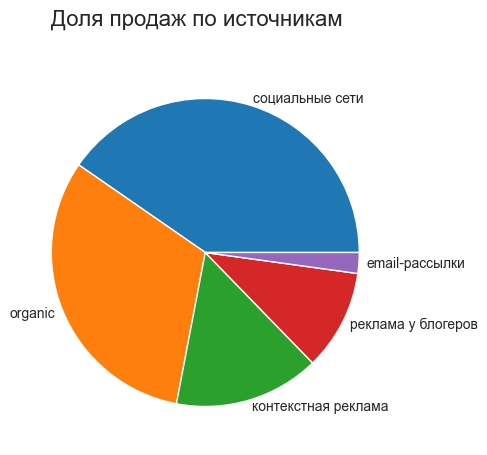

In [140]:
y = df.loc[df["payer"] == 1, "channel"].value_counts()
plt.figure(figsize=(7, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по источникам", size=16)

Text(0.5, 0.98, 'Доля продаж по устройствам')

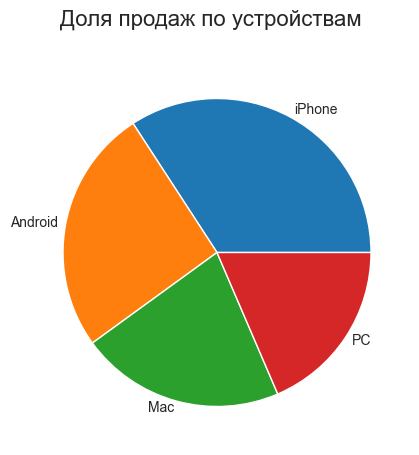

In [141]:
y = df.loc[df["payer"] == 1, "device"].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по устройствам", size=16)

Text(0.5, 0.98, 'Сезонность по дням недели')

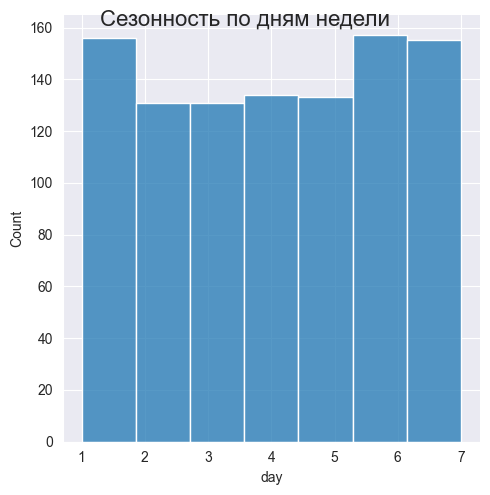

In [142]:
sns.displot(df["day"], bins=7)
plt.suptitle("Сезонность по дням недели", size=16)

Text(0.5, 0.98, 'Сезонность по месяцам')

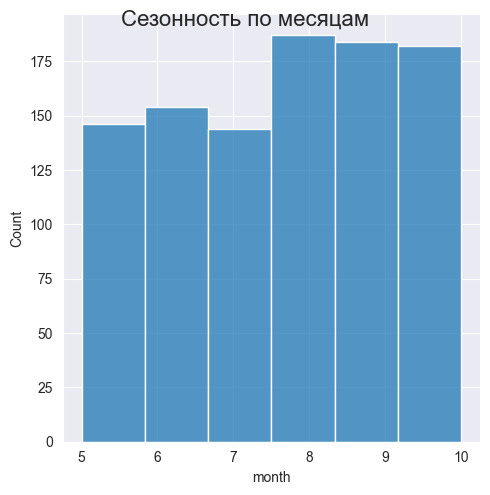

In [143]:
sns.displot(df["month"], bins=6)
plt.suptitle("Сезонность по месяцам", size=16)

Text(0.5, 0.98, 'Сезонность по времени дня')

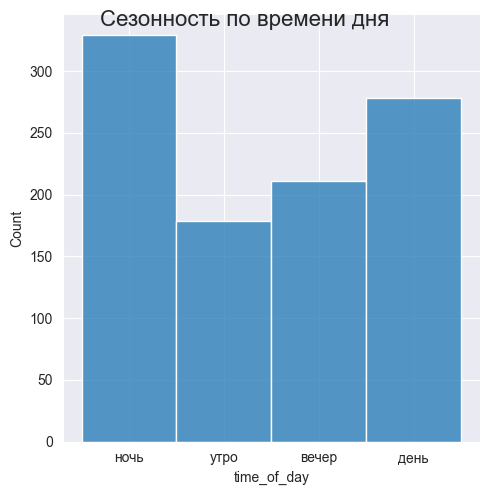

In [144]:
sns.displot(df["time_of_day"], bins=4)
plt.suptitle("Сезонность по времени дня", size=16)

Text(0.5, 0.98, 'Количество посетителей по регионам')

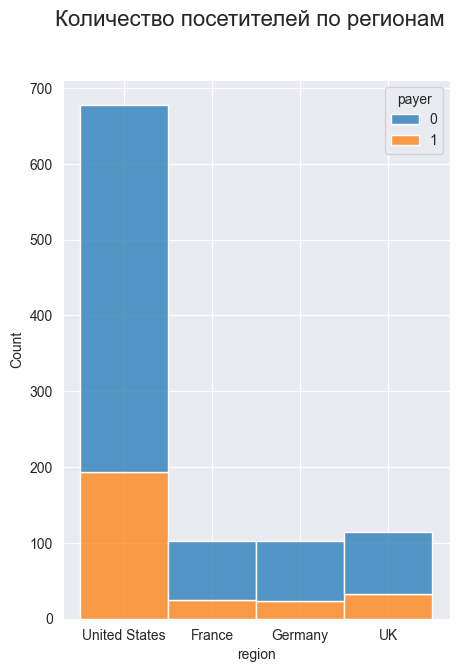

In [145]:
plt.figure(figsize=(5, 7))
sns.histplot(df, x="region", hue="payer", stat="count", multiple="stack")
plt.suptitle("Количество посетителей по регионам", size=16)

Text(0.5, 0.98, 'Количество посетителей по устройствам')

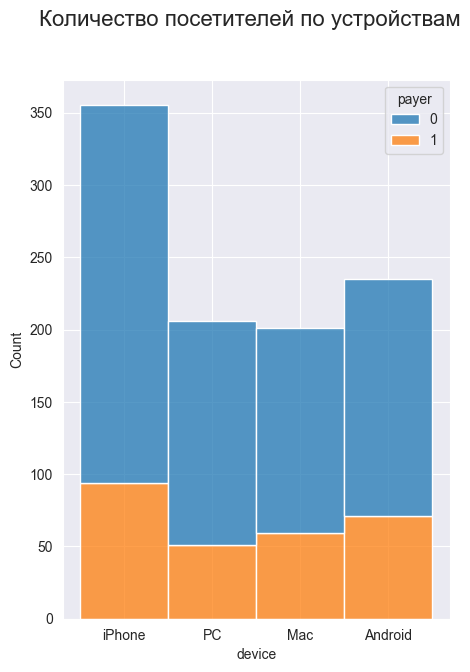

In [146]:
plt.figure(figsize=(5, 7))
sns.histplot(df, x="device", hue="payer", stat="count", multiple="stack")
plt.suptitle("Количество посетителей по устройствам", size=16)

Text(0.5, 0.98, 'Количество покупок по типу оплаты')

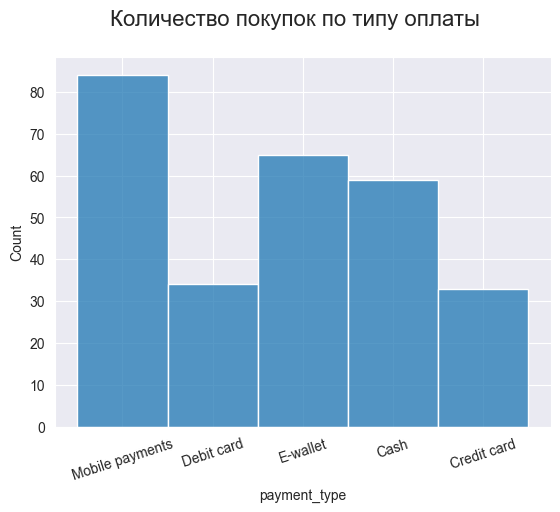

In [147]:
# Диаграмма количества покупок по типу оплаты
sns.histplot(df, x="payment_type", stat="count")
plt.xticks(rotation=18)
plt.suptitle("Количество покупок по типу оплаты", size=16)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'социальные сети'),
  Text(1, 0, 'organic'),
  Text(2, 0, 'реклама у блогеров'),
  Text(3, 0, 'контекстная реклама'),
  Text(4, 0, 'email-рассылки')])

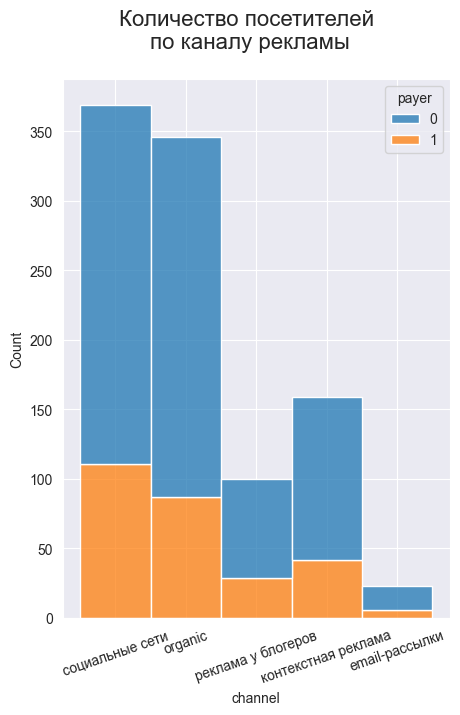

In [148]:
# По каналу рекламы
plt.figure(figsize=(5, 7))
sns.histplot(df, x="channel", hue="payer", stat="count", multiple="stack", cbar=False)
plt.suptitle("Количество посетителей \nпо каналу рекламы", size=16)
plt.xticks(rotation=19)

In [149]:
df.to_csv(r"ecom_processed.csv")

## Проведение расчетов

In [150]:
df = pd.read_csv('ecom_processed.csv')
df.head()

,Unnamed: 0,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,payer,time_of_day,final_price
0,0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,1,ночь,9999.0
1,1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,0,утро,NaN
2,2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,0,ночь,NaN
3,3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,0,вечер,NaN
4,4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,0,день,NaN


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          997 non-null    int64  
 1   user_id             997 non-null    int64  
 2   region              997 non-null    object 
 3   device              997 non-null    object 
 4   channel             997 non-null    object 
 5   session_start       997 non-null    object 
 6   session_end         997 non-null    object 
 7   sessiondurationsec  997 non-null    float64
 8   session_date        997 non-null    object 
 9   month               997 non-null    int64  
 10  day                 997 non-null    int64  
 11  hour_of_day         997 non-null    int64  
 12  order_dt            275 non-null    object 
 13  revenue             275 non-null    float64
 14  payment_type        275 non-null    object 
 15  promo_code          275 non-null    float64
 16  payer   

Средний чек

In [152]:
df.final_price.mean().round(2)

5416.09

Среднее кол-во покупок от пользователя

In [153]:
df.payer.mean().round(2)

0.28

Средняя продолжительность сессии по каналам рекламы

In [154]:
df.groupby('channel').sessiondurationsec.mean().round(2)

channel
email-рассылки         1919.26
organic                1725.96
контекстная реклама    1871.79
реклама у блогеров     1669.64
социальные сети        1602.86
Name: sessiondurationsec, dtype: float64

Средняя продолжительность сессии по типу устройства

In [155]:
df.groupby('device').sessiondurationsec.mean().round(2)

device
Android    1801.14
Mac        1616.55
PC         1806.77
iPhone     1625.27
Name: sessiondurationsec, dtype: float64

Топ-3 рекламных канала по среднему чеку

In [156]:
df.groupby('channel').final_price.mean().sort_values(ascending=False).round(2).head(3)

channel
социальные сети       5525.13
organic               5433.48
реклама у блогеров    5388.66
Name: final_price, dtype: float64

Топ-3 региона по среднему чеку

In [157]:
df.groupby('region').final_price.mean().sort_values(ascending=False).round(2).head(3)

region
UK               5555.25
United States    5423.23
Germany          5344.83
Name: final_price, dtype: float64

Топ-3 месяца по среднему чеку с разбивкой по регионам

In [158]:
def func_month(x):
    if x == 5:
        return "May"
    if x == 6:
        return "June"
    if x == 7:
        return "July"
    if x == 8:
        return "August"
    if x == 9:
        return "September"
    if x == 10:
        return "October"


df['month'] = pd.DatetimeIndex(df['session_date']).month
df['month'] = df['month'].apply(func_month)

In [159]:
reg_df = pd.DataFrame()
reg_df['region'] = ['United States'] * 6 + ['France'] * 6 + ['Germany'] * 6 + ['UK'] * 6
reg_df['month'] = ['May', 'June', 'July', 'August', 'September', 'October'] * 4
reg_df['mean_price'] = list(df.groupby(['region', 'month']).final_price.mean().round(2))
reg_df

,region,month,mean_price
0,United States,May,4999.00
1,United States,June,4999.00
2,United States,July,5499.00
3,United States,August,5449.00
4,United States,September,5165.67
5,United States,October,4999.00
6,France,May,4987.89
7,France,June,7499.00
8,France,July,5679.00
9,France,August,4665.67


In [160]:
reg_df.groupby(['region', 'month']).agg({'mean_price':sum})['mean_price'].groupby('region', group_keys=False).apply(lambda x : x.sort_values(ascending=False).head(3))

/var/folders/25/m60d5xvj3xv0532z7xrhjnl00000gp/T/ipykernel_77778/7067282.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  reg_df.groupby(['region', 'month']).agg({'mean_price':sum})['mean_price'].groupby('region', group_keys=False).apply(lambda x : x.sort_values(ascending=False).head(3))


region         month    
France         June         7499.00
               July         5679.00
               October      5249.00
Germany        September    6056.14
               August       5999.00
               May          5610.11
UK             August       6051.17
               May          5567.09
               July         5459.00
United States  July         5499.00
               August       5449.00
               September    5165.67
Name: mean_price, dtype: float64

MAU* по каждому месяцу с разбивкой по рекламным каналам *MAU (Monthly Active Users) — это количество уникальных пользователей за месяц.

In [161]:
df.groupby(['month', 'channel']).agg({'user_id':pd.Series.nunique})

user_id
month     channel                     
August    email-рассылки             4
          organic                   60
          контекстная реклама       35
          реклама у блогеров        20
          социальные сети           68
July      email-рассылки             3
          organic                   46
          контекстная реклама       24
          реклама у блогеров        15
          социальные сети           56
June      email-рассылки             1
          organic                   59
          контекстная реклама       28
          реклама у блогеров        13
          социальные сети           53
May       email-рассылки             7
          organic                   76
          контекстная реклама        8
          реклама у блогеров        14
          социальные сети           41
October   email-рассылки             6
          organic                   47
          контекстная реклама       26
          реклама у блогеров        18
          социальные сети           85
September email-рассылки             2
          organic                   58
          контекстная реклама       38
          реклама у блогеров        20
          социальные сети           66

In [162]:
df.groupby(['month', 'channel']).agg({'user_id': pd.Series.nunique})
chan_df = pd.DataFrame()
chan_df['channel'] = df['channel'].unique()
chan_df['users'] = chan_df['channel'].apply(lambda x: df[df['channel'] == x].shape[0])
chan_df['unique_users'] = chan_df['channel'].apply(lambda x: len(df[df['channel'] == x].user_id.unique()))
chan_df['paying_users'] = chan_df['channel'].apply(lambda x: df[df['channel'] == x].payer.sum())
chan_df['overall_revenue'] = chan_df['channel'].apply(lambda x: df[df['channel'] == x].revenue.sum())
chan_df.sort_values(by='overall_revenue', ascending=False)

,channel,users,unique_users,paying_users,overall_revenue
0,социальные сети,369,369,111,629889.0
1,organic,346,346,87,487913.0
3,контекстная реклама,159,159,42,223958.0
2,реклама у блогеров,100,100,29,157971.0
4,email-рассылки,23,23,6,32994.0


## Гипотезы

In [163]:
df = pd.read_csv('ecom_processed.csv')
df.head()

,Unnamed: 0,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,payer,time_of_day,final_price
0,0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,1,ночь,9999.0
1,1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,0,утро,NaN
2,2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,0,ночь,NaN
3,3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,0,вечер,NaN
4,4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,0,день,NaN


#### Гипотеза 1: Влияет ли тип устройства на количество покупок в день по каждому региону?

In [164]:
for region in df.region.unique():
    work_with = df[df['region'] == region]
    devices = {
        'iPhone':None,
        'PC':None,
        'Mac':None,
        'Android':None
    }
    norm = False
    for device in devices:
        devices[device] = pd.DataFrame(work_with[work_with['device'] == device].groupby('session_date').agg({'payer':'sum'})).reset_index()['payer']
        if stats.shapiro(devices[device])[1] >= 0.05:
            norm = True
    if norm:
        method = 'ANOVA'
        p = stats.f_oneway(*devices.values())[1]
    else:
        method = 'критерий Краскела-Уоллеса'
        p = stats.kruskal(*devices.values())[1]
    print(f'Для региона {region} распределение дней {"не" if not norm else ""}нормальное, поэтому, используя {method} мы подсчитали p-уровень {round(p, 2)}')
    true = round(p, 2) <= 0.05
    print(f'p-уровень {"больше" if not true else "меньше"} 0.05, поэтому мы {"отвергаем" if true else "принимаем"} нулевую гипотезу, а следовательно, в этом '
          f'регионе зависимост{"ь есть" if true else "и нет"}.')
    print('----------------------------------')

Для региона United States распределение дней ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.39
p-уровень больше 0.05, поэтому мы принимаем нулевую гипотезу, а следовательно, в этом регионе зависимости нет.
----------------------------------
Для региона France распределение дней ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.19
p-уровень больше 0.05, поэтому мы принимаем нулевую гипотезу, а следовательно, в этом регионе зависимости нет.
----------------------------------
Для региона Germany распределение дней ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.76
p-уровень больше 0.05, поэтому мы принимаем нулевую гипотезу, а следовательно, в этом регионе зависимости нет.
----------------------------------
Для региона UK распределение дней ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.74
p-уровень больше 0.05, поэтому мы принимаем нулевую ги

Не влияет

#### Гипотеза 2: Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

Здесь можно проверить аналогичным способом

In [165]:
for region in df.region.unique():
    work_with = df[df['region'] == region]
    no = []
    channels = {channel:None for channel in df['channel'].unique()}
    norm = False
    for channel in channels:
        channels[channel] = pd.DataFrame(work_with[work_with['channel'] == channel].groupby('session_date').agg({'payer':'sum'})).reset_index()['payer']
        if len(channels[channel]) == 0:
            no.append(channel)
            continue
        if stats.shapiro(channels[channel])[1] >= 0.05:
            norm = True
    for n in no:
        del channels[n]
    if norm:
        method = 'ANOVA'
        p = stats.f_oneway(*channels.values())[1]
    else:
        method = 'критерий Краскела-Уоллеса'
        p = stats.kruskal(*channels.values())[1]
    print(f'Для региона {region} распределение просмотров по дням {"не" if not norm else ""}нормальное, поэтому, используя {method} мы подсчитали p-уровень {round(p, 2)}')
    true = round(p, 2) <= 0.05
    print(f'p-уровень {"больше" if not true else "меньше"} 0.05, поэтому мы {"отвергаем" if true else "принимаем"} нулевую гипотезу, а следовательно, в этом '
          f'регионе зависимост{"ь есть" if true else "и нет"}.')
    if no:
        print(f"!ВНИМАНИЕ! Учесть, что в регионе отсутству{'ю' if len(no) > 1 else 'е'}т канал{'ы' if len(no) > 1 else ''} {','.join(no)}")
    print('----------------------------------')

Для региона United States распределение просмотров по дням ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.03
p-уровень меньше 0.05, поэтому мы отвергаем нулевую гипотезу, а следовательно, в этом регионе зависимость есть.
!ВНИМАНИЕ! Учесть, что в регионе отсутствует канал email-рассылки
----------------------------------
Для региона France распределение просмотров по дням ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.15
p-уровень больше 0.05, поэтому мы принимаем нулевую гипотезу, а следовательно, в этом регионе зависимости нет.
!ВНИМАНИЕ! Учесть, что в регионе отсутствует канал социальные сети
----------------------------------
Для региона Germany распределение просмотров по дням ненормальное, поэтому, используя критерий Краскела-Уоллеса мы подсчитали p-уровень 0.91
p-уровень больше 0.05, поэтому мы принимаем нулевую гипотезу, а следовательно, в этом регионе зависимости нет.
!ВНИМАНИЕ! Учесть, что в регионе от

В США влияет, в других регионах нет

#### Гипотеза 3: Средний чек отличается в зависимости от региона

<Axes: xlabel='final_price', ylabel='Count'>

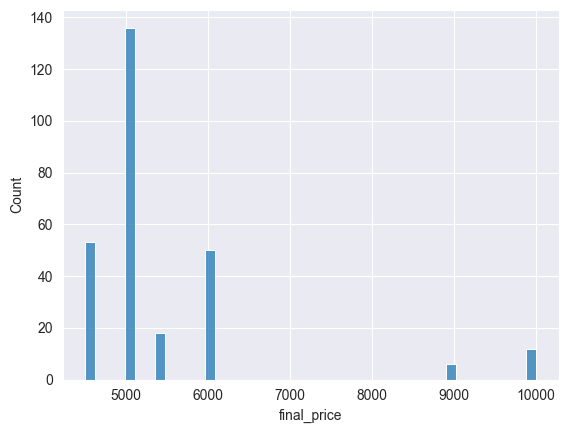

In [166]:
sns.histplot(x=df.final_price)

In [167]:
us = df.loc[df['region'] == 'United States', 'final_price'].dropna()
france = df.loc[df['region'] == 'France', 'final_price'].dropna()
germany = df.loc[df['region'] == 'Germany', 'final_price'].dropna()
uk = df.loc[df['region'] == 'UK', 'final_price'].dropna()

(array([19.,  2.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([4499., 5049., 5599., 6149., 6699., 7249., 7799., 8349., 8899.,
        9449., 9999.]),
 <BarContainer object of 10 artists>)

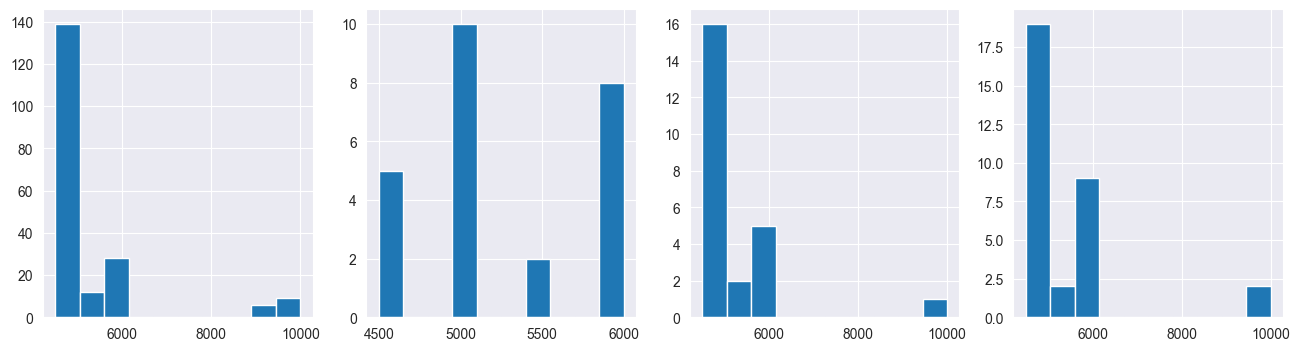

In [168]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.hist(us)
ax2.hist(france)
ax3.hist(germany)
ax4.hist(uk)

In [169]:
us = df.loc[df['region'] == 'United States', 'final_price'].dropna()
france = df.loc[df['region'] == 'France', 'final_price'].dropna()
germany = df.loc[df['region'] == 'Germany', 'final_price'].dropna()
uk = df.loc[df['region'] == 'UK', 'final_price'].dropna()

(array([19.,  2.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([4499., 5049., 5599., 6149., 6699., 7249., 7799., 8349., 8899.,
        9449., 9999.]),
 <BarContainer object of 10 artists>)

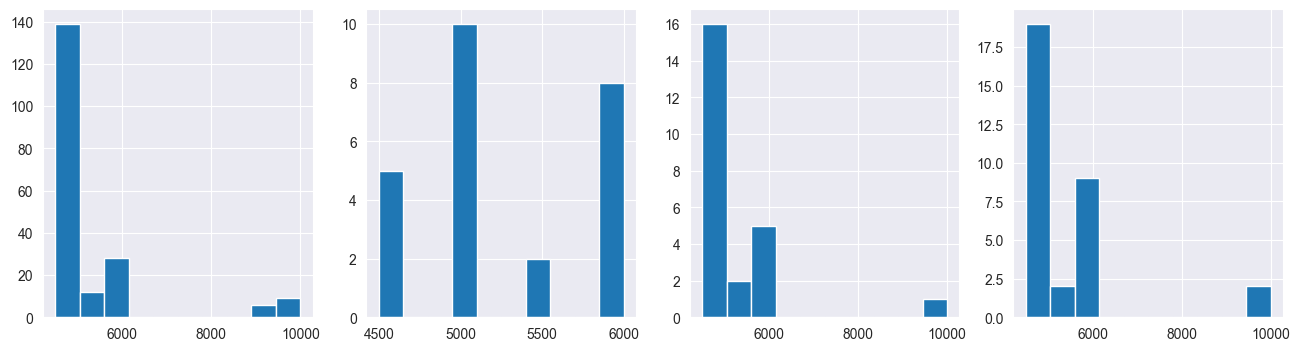

In [170]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.hist(us)
ax2.hist(france)
ax3.hist(germany)
ax4.hist(uk)

Распределение ненормальное, используем критерий Краскела

In [171]:
stats.kruskal(us, france, germany, uk)[1].round(2)

0.51

P-value больше 0.05, а значит чек не зависит от региона => не отличается

#### Гипотеза 4: средний чек отличается в зависимости от рекламного канала

Проверка аналогичная проверке выше

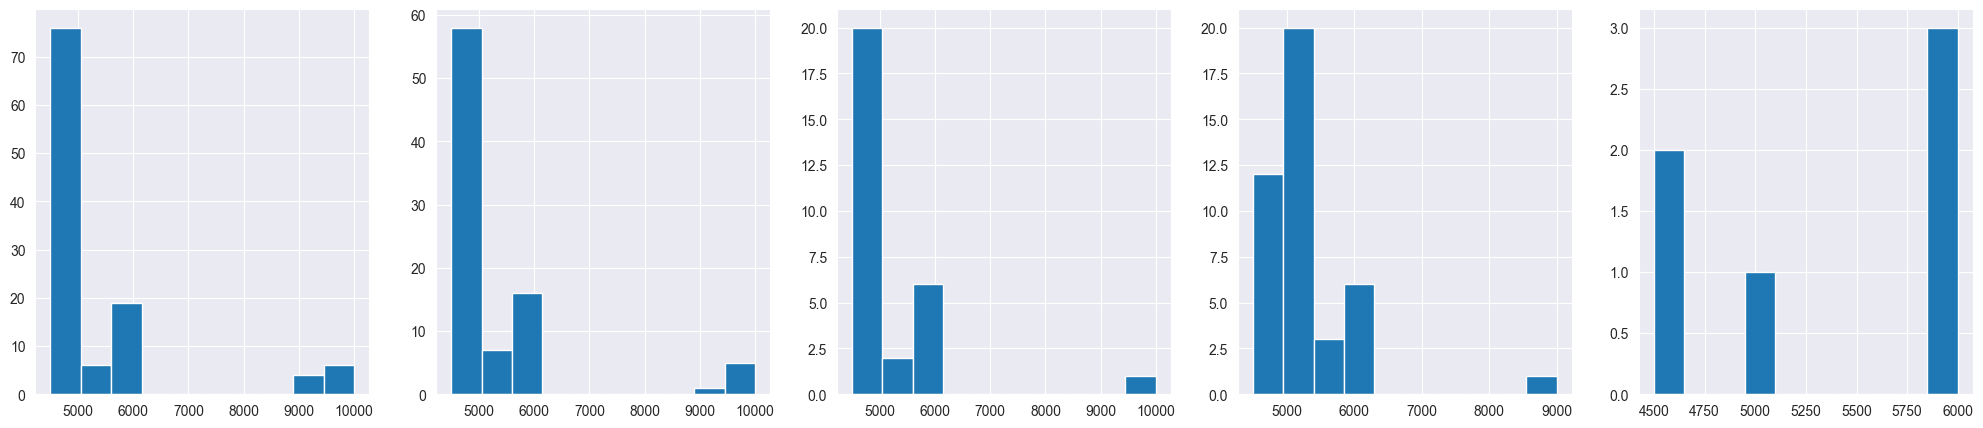

In [172]:
channels = {channel:None for channel in df['channel'].unique()}
for channel in channels:
    channels[channel] = df.loc[df['channel'] == channel, 'final_price'].dropna()
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
ax = 0
for ch in channels:
    axes[ax].hist(channels[ch])
    ax += 1

Распределение ненормальное, используем Краскела

In [173]:
stats.kruskal(*channels.values())[1].round(2)

0.38

P-value больше 0.05, гипотеза не подтвердилась

In [ ]:
df = pd.read_csv('ecom_processed.csv', sep=',', decimal=".")
df.head()

### Гипотеза 5: средний чек отличается в зависимости от времени суток

In [ ]:
time_of_day = ['ночь', 'утро', 'день', 'вечер']
data_time_of_day = {}
for time in time_of_day:
    final_price = df.loc[(df["time_of_day"] == time) & (df["payer"] == 1)]["final_price"]
    data_time_of_day[time] = final_price
    print(f"{time.capitalize()}: {round(final_price.mean(), 2)}")

Исходя из средних значений, есть увеличение среднего чека вечером и ночью.

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.hist(data_time_of_day[time_of_day[0]])
ax2.hist(data_time_of_day[time_of_day[1]])
ax3.hist(data_time_of_day[time_of_day[2]])
ax4.hist(data_time_of_day[time_of_day[3]])

Так как распределение ненормальное, применяем критерий Краскела

In [ ]:
round(stats.kruskal(*data_time_of_day)[1], 2)

P-value больше 0.05, статистически значимого результата нет

### Гипотеза 6: есть взаимосвязь между продолжительностью сессии с суммой покупок

In [ ]:
data_only_purchases = df.dropna()
if stats.shapiro(data_only_purchases["final_price"])[1] >= 0.05 and stats.shapiro(data_only_purchases["sessiondurationsec"])[1] >= 0.05:
    print("Распределение нормальное, используем метод Пирсона")
    pval = stats.pearsonr(data_only_purchases["final_price"], data_only_purchases["sessiondurationsec"])
else:
    print("Распределение ненормальное, используем метод Спирмена")
    pval = stats.spearmanr(data_only_purchases["final_price"], data_only_purchases["sessiondurationsec"])
print(pval[1])

P-value больше 0.05, статистически значимого результата нет

### Гипотеза 7: есть взаимосвязь продолжительности сеанса и типа устройства

In [ ]:
devices = df["device"].unique()
data_devices = {}
for device in devices:
    session = df.loc[df["device"] == device, "sessiondurationsec"]
    data_devices[device] = session
    print(f"{device.capitalize()}: {round(session.mean(), 2)}")

In [ ]:
for device in devices:
    if stats.shapiro(data_devices[device])[1] >= 0.05:
        print(f"Распределение в группе {device} нормальное")

Во всех группах распределение ненормальное, используем метод Краскела

In [ ]:
round(stats.kruskal(*data_devices)[1], 2)

P-value больше 0.05, статистически значимой корреляции не обнаружено

### Гипотеза 8: есть взаимосвязь продолжительности сеанса и типа рекламного канала

In [ ]:
channels = df["channel"].unique()
data_channels = {}
for channel in channels:
    session = df.loc[df["channel"] == channel, "sessiondurationsec"]
    data_channels[channel] = session
    print(f"{channel.capitalize()}: {round(session.mean(), 2)}")

In [ ]:
for channel in channels:
    if stats.shapiro(data_channels[channel])[1] >= 0.05:
        print(f"Распределение в группе {channel} нормальное")

Во всех группах распределение ненормальное, используем метод Краскела

In [ ]:
round(stats.kruskal(*data_channels)[1], 2)

P-value больше 0.05, статистически значимой корреляции не обнаружено

## Регрессионное моделирование

In [ ]:
df_pure = pd.read_csv('ecom_processed.csv', sep=',', decimal=".")
data = pd.DataFrame()
data["month"] = df_pure["month"].unique()
df = df_pure.dropna()
df.head()

### Регрессионная модель 1: прогнозируем сумму покупки

In [ ]:
def func(price):
    prices = df["final_price"].unique()
    return min(prices, key=lambda x:abs(x-price))

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
df["device"] = ohe.fit_transform(df[["device"]])
factors = df[["sessiondurationsec", "device", "day"]]
target = df["final_price"]
x_train, x_test, y_train, y_test = train_test_split(factors, target, random_state=42, test_size=0.25)
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
prediction = lin_reg.predict(x_test)
prediction = list(map(func, list(prediction)))
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, prediction), 5)}")

Факторами, позволяющими определить сумму покупки оказались продолжительность сессии, устройство и день недели

In [ ]:
data["users"] = data["month"].apply(lambda x: len(df_pure.loc[df_pure["month"] == x]))
data["purchases"] = data["month"].apply(lambda x: len(df_pure.loc[(df_pure["month"] == x) & (df_pure["payer"] == 1)]))
data["united_states"] = data["month"].apply(lambda x: len(df_pure.loc[(df_pure["month"] == x) & (df_pure["region"] == "United States")]))
data.head(6)

### Регрессионная модель 2: прогнозируем количество покупателей за месяц

In [ ]:
factors = data[["users", "united_states"]]
target = data["purchases"]
x_train, x_test, y_train, y_test = train_test_split(factors, target, random_state=42, test_size=0.20)
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
prediction = lin_reg.predict(x_test)
prediction = round(prediction)
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, prediction), 5)}")